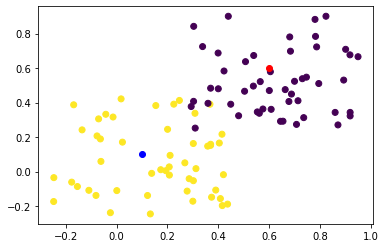

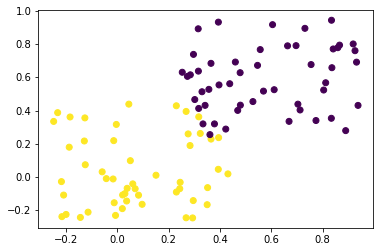

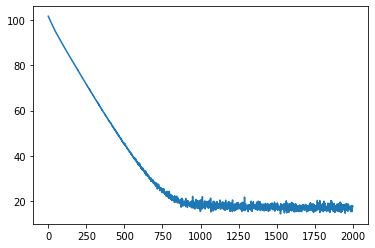

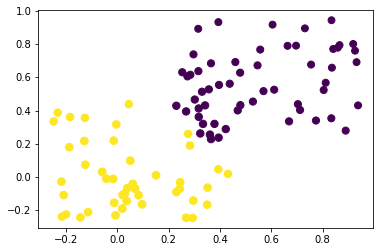

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 789.84it/s]


In [1]:

import sys
sys.path.append("..")



from functools import partial

import matplotlib.pyplot as plt

import seaborn

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist
from tqdm import trange
import tyxe

pyro.set_rng_seed(42)

def make_blobs(scale=0.7, center = 0.25):
    x1 = torch.rand(50, 2) * scale - center
    x2 = torch.rand(50, 2) * scale + center

    y1 = torch.ones(50,1)
    y2 = torch.zeros(50,1)

    x = torch.cat([x1, x2])
    y = torch.cat([y1, y2])
    return x, y


scale=0.7
center = 0.25
x, y = make_blobs(scale, center)

plt.scatter(x[:,0], x[:,1], c=y)
plt.scatter(scale*0.5+center, scale*0.5+center, c='r')
plt.scatter(scale*0.5-center, scale*0.5-center, c='b')
plt.show()

x_test, y_test = make_blobs()
plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plt.show()

dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=int(len(x)/5))


net = nn.Sequential(nn.Linear(2, 5), nn.ReLU(inplace=True), nn.Linear(5, 1), nn.Sigmoid())
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.Bernoulli(int(len(x)/5), logit_predictions=False, event_dim=1)
guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide)



pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    elbos.append(e)
    
with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 2000, callback)

plt.plot(elbos)
plt.show()

y_pred = bnn.predict(x_test, num_predictions=32, aggregate=False)
y_out = y_pred.squeeze().T
m = y_out.mean(axis=1)
sd = y_out.std(axis=1)

plt.scatter(x_test[:,0], x_test[:,1], c=m>0.5, s=(1-sd*2)*100 )
plt.show()


# Deterministic net for comparission
det_net = nn.Sequential(nn.Linear(2, 5), nn.ReLU(inplace=True), nn.Linear(5, 1), nn.Sigmoid())
optim = torch.optim.Adam(det_net.parameters(), 1e-4)
for _ in trange(10000):
    optim.zero_grad()
    det_net(x).sub(y).pow(2).mean().backward()
    optim.step()

pred =  det_net(x_test).detach()